# UMAP (Uniform Manifold Approximation and Projection)

## Introduction

UMAP is a dimensionality reduction technique, which can  also be used for visualization. 

Unlike a PCA, it can do non-linear dimensionality reduction and tries to capture the local structure and the global structure in the low-dimensional space

In a lot of ways , it is similar philosophically to tSNE, but there are differences as well.  The basic philosophy is similar to TSNE, find similarities between all pairs of points in high dimensions, and ensure that the similarities in lower dimensions are similar to the high dimensions, but the details differ

## Assumptions

UMAP assumes that

1) The data is uniformly distributed on Riemannian manifold;

2) The Riemannian metric is locally constant (or can be approximated as such);

3) The manifold is locally connected.

## How does it work ?

UMAP draws a lot of its intuition from manifold learning and topological data analysis techniques, for more details, look here https://umap-learn.readthedocs.io/en/latest/how_umap_works.html

However using the theoretical justifications drawn from manifold learning and topological analysis, the implementation becomes fairly simple and we're going to follow the statquest videos https://www.youtube.com/watch?v=eN0wFzBA4Sc
https://www.youtube.com/watch?v=jth4kEvJ3P8 to look at some detail

## Details

In UMAP , we want to convert points in high-dimensional space (left) to the low dimensional space (right) 
such that points which are close in the high dimensional space are close in the low dimensional space, and points far away in the high dimensional space are far away in the low dimensional space . Thus, we aim to preserve the local-structure

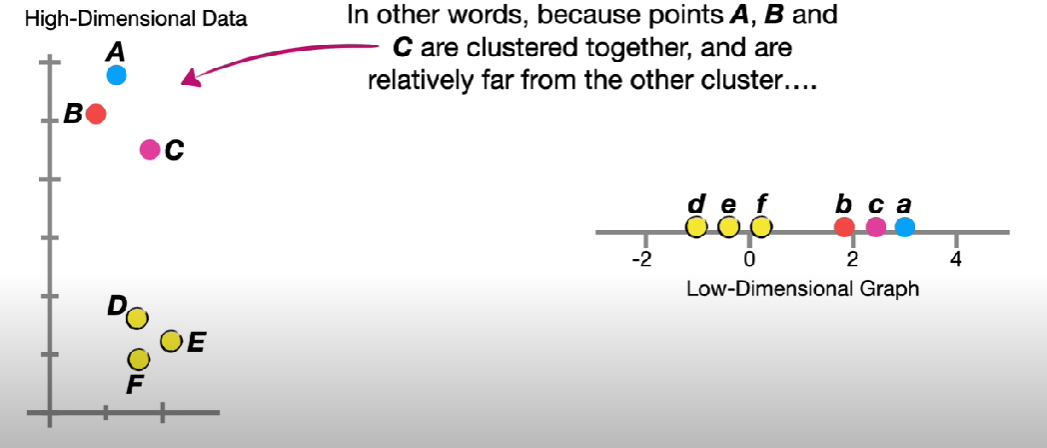

In PCA, using the above diagram as a motivating example, you would choose a line in the X-Y place to project all the points on

But UMAP doesn't do anything so simple

Here's what UMAP does


1) First pick 1 point - Let's say A. Then you compute similarity scores of all other points with respect to A. Discard points whose similarity scores are very less

Mathematically, this equation is used to compute the similarity score between A (the reference point) and some other point

S = $e^{-\frac{raw dist - dist to nearest neighbour}{\sigma}}$

Which if you calculate over all other points gives a curve which has this shape

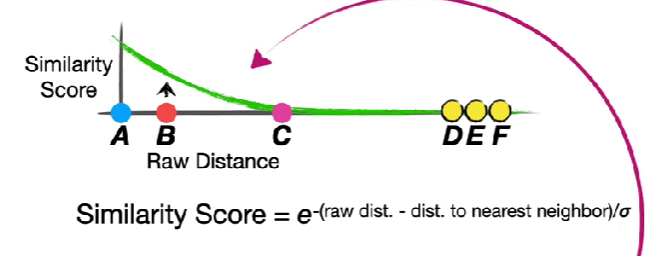


The point closest to A (ie nearest neighbour - let's say it is B) has S = 1 always, because the numerator becomes 0 independent of $\sigma$

The main hyperparameter in UMAP is the number of nearest neighbours (in the high dimensional data set) which determines the value of $\sigma$ in the equation above, and hence the shape of the curve

The number of nearest neighbours in includes the count of the point itself. n=15 is a common choice in UMAP, but assume n=3 here for illustration 

Now $log_{2}{n}$ is the sum you want to get by adding the similarity scores above. So you adjust $\sigma$ such that you get to th sum above

For example, if n, the number of nearest neighbours you want is 3,  $log_{2}{3}$ = 1.6


Assume you have the raw distances as below using six points A to F

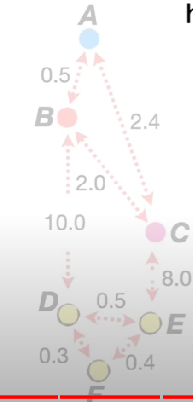

Focusing on point A, assume that points D,E,F are very far away from A, so you can ignore them for the similarity score calcuation

This leaves only B and C

You want to choose $\sigma$ in the similarity curve for B and C from A such that


SAB + SAC = 1.6

ie

$e^{-\frac{0.5 - 0.5}{\sigma}}$ + $e^{-\frac{2.4 - 0.5}{\sigma}}$ = 1.6

Solving for this, a $\sigma$ of 3.5, this equation gets satisfied



#### TSNE note 1 : One difference from TSNE at this stage - TSNE also computes pairwise similarity, but uses gaussian curves to compute similarity, and the widths and heights of the guassian curves are determined by a hyperparameter called perplexity, which plays a role similar to number of nearest neighbours in UMAP


2) Repeat the same to compute similarity scores for every other point B to F to all other points

This way, you get all pairs of similarity scores AB, AC, BA, BC, etc etc

3) Note that because of the way the similarity scores are calcuated, they are not symmetric ie AB need not be equal to BA

Now we have to symmetricize then 

The formula used for this in UMAP is
Symmetrical score  = (S1 + S2) - S1S2 , where S1 for example is the similarity from A to B if A is the reference, S2 is the the similarity from B to A if B is the reference. This formula comes from the fuzzy union operation in the underlying theory of UMAP

#### TSNE note  2: One difference from TSNE at this stage - TSNE also computes symmetric similarity, but just uses 0.5*(S1 + S2)



At the end of this, in the high dimensional space, we get similarity scores for every pair

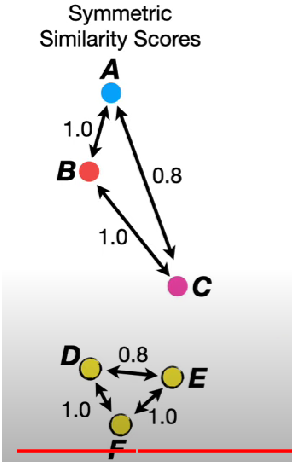


4) #### Now, we move to the low-dimensional space. 
First, a low dimensional graph is initialized using spectral embedding

Initialized low dimension graph example 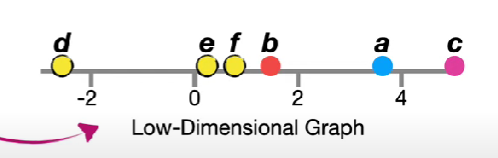

#### TSNE note  3: One difference from TSNE at this stage - TSNE does random initialization in low dimensions, whereas UMAP initialization is deterministic


5) Now, we essentially have to move point(s) in the low dimensional space such that you arrive at a local similarity structure similar to the high dimensional space

To compute similarity scores in the low-dimension, UMAP makes a t-distribution assumption.
It uses this equation  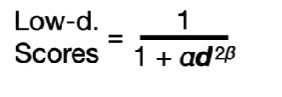  to compute a low - dimensional similarity score where d is the distance between the pair of points in the low dimension, $\alpha$ and $\beta$ are hyperparameters, which control how tightly points are packed together in the lower dimension
By default, $\alpha$ = 1.577, $\beta$ = 0.8951

The maximum value the equation above can take is if d=0 (two points right on top of each other in low dimensional space), which gives a similarity of 1

#### TSNE note  4: TSNE uses the equation $\frac{1}{1 + d^{2}}$ which is what you get if $\alpha$ = 1 and $\beta$ = 1


First, Pick a pair of low dimensional points to move closer to each other (random selection proportional to the high dimensional score)

For example, it might decide to choose the pair AB. Then UMAP flips another coin and decides it wants to move B closer to A

So we compute the low dimensional score of AB = 0.14 using equation above

Now UMAP picks a point B should move away from (randomly picks a point not in B's neighbourhood, ignoring the exact high dimensional score). Let's say it picks E

Now again , the score between B and E is computed using equation above = 0.23

So we have two scores, 0.14 (score for point in same neighbourhood as B, which B needs to move closer to ) and 0.23 (score for point in different neighbourhood as B, which B needs to move away from)

You can set up a cost function using these two scores to evaluate where B needs to move to ! using gradient descent


Cost function = $log(\frac{1}{neighbour similarity score}) + log(\frac{1}{1 - Not neighbour similarity score})$


You want to get the location of B which minimizes this cost function using gradient descent





Now you do the same thing starting with all other points, use stochastic gradient descent

(Because stochastic gradient descent is random, if you use UMAP multiple times, the results might be a bit different)


#### TSNE note  5: TSNE moves every single point a little bit in each iteration, UMAP can move just 1 point or a small subset of points each iteration, so it scales well with big datasets



#### TSNE note 6 : For larger data sets UMAP is much faster than TSNE - Why ? 

This is not naturally intuitive as both are O(N^2) algorithms, requiring pairwise similarity computation in the high dimensional space

One point is above, where TSNE moves every single point in every iteration, UMAP just moves 1 point or a small subset of points


This quora post gives more reasons (Not entirely sure of correctness) https://www.quora.com/Why-exactly-is-UMAP-faster-than-TSNE

Basically, TSNE has the normalization term in the high dimension which UMAP doesn't, this is expensive
TSNE has a log computation in high dimension (huh ? ), UMAP doesn't


## References

1) https://umap-learn.readthedocs.io/en/latest/
2) https://arxiv.org/abs/1802.03426
3) https://www.youtube.com/watch?v=eN0wFzBA4Sc
4) https://www.youtube.com/watch?v=jth4kEvJ3P8